In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [2]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

import random 
from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from models.autoencoder import VariationalAutoEncoder, AutoEncoder
from models.mlp import MLP
from utils.data_utils import TorchDataset

from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
thefts = pd.read_csv("../dataset/final/valid_train_thefts.csv")
non_thefts = pd.read_csv("../dataset/final/valid_train_non_theft_suc_theft_acct.csv")

df = pd.concat([thefts, non_thefts])
df.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
df.fillna(-1, inplace=True)

In [5]:
scaler = MinMaxScaler()

In [6]:
#df.drop(['xrhsh', 'parno', 'acct_control', 'contract_capacity', 'min_measurement_interval_in_days', 'max_energy_per_day'], axis=1, inplace=True)
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0    2094
1    1555
Name: target, dtype: int64


In [7]:
df.head()

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,15,144.181818,122.0,152,0,1,12.0,0,0,1
1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,6,122.416667,121.0,341,0,1,12.0,0,1,1
2,5,5,0.000000,0.000000,0.000000,0.000000,0.000000,125,120,122.250000,122.0,1251,2,1,25.0,0,3,1
3,6,1,9.434066,4.546448,5.873035,4.989218,1.803735,371,68,197.200000,182.0,190,2,6,25.0,0,0,1
4,8,0,19.565574,1.910569,10.585130,10.008197,5.580233,246,121,139.142857,121.0,821,3,1,35.0,0,5,1


In [8]:
train = df[df['target'] == 0]
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

test_target1 = df[(df['target'] == 1)]

In [9]:
train.target.value_counts(), val.target.value_counts(), test_target1.target.value_counts()

(0    1675
 Name: target, dtype: int64,
 0    419
 Name: target, dtype: int64,
 1    1555
 Name: target, dtype: int64)

In [10]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']
X_test_1 = test_target1.drop('target', axis=1)
y_test_1 = test_target1['target']

In [11]:
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test_1 = scaler.transform(X_test_1)

In [12]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

test_dataset_one = TorchDataset(
    X=torch.tensor(X_test_1).float(),
    y=torch.tensor(y_test_1.to_numpy()).float()
)

X_test = np.concatenate([X_val, X_test_1], axis=0)
y_test = pd.concat([y_val, y_test_1])
test_dataset = TorchDataset(
    X=torch.tensor(X_test).float(),
    y=torch.tensor(y_test.to_numpy()).float()
)

In [13]:
np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

(array([1675]), array([419]), array([ 419, 1555]))

In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)
test_zero = DataLoader(
    test_dataset_one, batch_size=1, shuffle=False
)

In [15]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[16, 8],
    out_size=4,
    vae=True)
decoder = MLP(
    in_size=4, 
    layer_units=[8, 16],
    out_size=X_train.shape[1],
)
model = VariationalAutoEncoder(encoder, decoder)
model

VariationalAutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=17, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=4, bias=True)
      (5): ReLU()
    )
    (mu): Linear(in_features=4, out_features=4, bias=True)
    (logvar): Linear(in_features=4, out_features=4, bias=True)
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=17, bias=True)
    )
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.SmoothL1Loss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
args = dict(model=model, train_loader=train_loader, 
            test_loader=val_loader,
            epochs=1_000, optimizer=optimizer, 
            criterion=criterion,
            reconstruction=True, vae=False,
            device=device, verbose=True, return_best=True)

Epoch: 1/1000
[Train]	Loss=0.09978834455305675
[Test]	Loss=0.09106217005423137

Epoch: 2/1000
[Train]	Loss=0.07845255570872775
[Test]	Loss=0.054980773744838576

Epoch: 3/1000
[Train]	Loss=0.03341816569555481
[Test]	Loss=0.019449930238936628

Epoch: 4/1000
[Train]	Loss=0.01490754542766877
[Test]	Loss=0.012366561684757471

Epoch: 5/1000
[Train]	Loss=0.011141241062432528
[Test]	Loss=0.010121000265436513

Epoch: 6/1000
[Train]	Loss=0.008887337336211273
[Test]	Loss=0.008674184991312879

Epoch: 7/1000
[Train]	Loss=0.008034169928715477
[Test]	Loss=0.008205680542492442

Epoch: 8/1000
[Train]	Loss=0.007673500729549043
[Test]	Loss=0.007913514572594847

Epoch: 9/1000
[Train]	Loss=0.0073832722626767065
[Test]	Loss=0.007636269787326455

Epoch: 10/1000
[Train]	Loss=0.007089702456416386
[Test]	Loss=0.007318924347470913

Epoch: 11/1000
[Train]	Loss=0.006773924252967227
[Test]	Loss=0.006997281618948493

Epoch: 12/1000
[Train]	Loss=0.006485994562576964
[Test]	Loss=0.0067698357826364896

Epoch: 13/1000
[

Epoch: 101/1000
[Train]	Loss=0.002870599543763641
[Test]	Loss=0.003733097542343395

Epoch: 102/1000
[Train]	Loss=0.002861979859002497
[Test]	Loss=0.0036847779826660243

Epoch: 103/1000
[Train]	Loss=0.002852105539959838
[Test]	Loss=0.0037317129567132463

Epoch: 104/1000
[Train]	Loss=0.0028432536988853003
[Test]	Loss=0.0036679682255323443

Epoch: 105/1000
[Train]	Loss=0.002832413719141118
[Test]	Loss=0.0037107815317410442

Epoch: 106/1000
[Train]	Loss=0.002825567518571778
[Test]	Loss=0.003713392070494592

Epoch: 107/1000
[Train]	Loss=0.002817049615946159
[Test]	Loss=0.0036475305262553903

Epoch: 108/1000
[Train]	Loss=0.002808189291928737
[Test]	Loss=0.0037014124183250324

Epoch: 109/1000
[Train]	Loss=0.0028041450434171085
[Test]	Loss=0.003700795317334788

Epoch: 110/1000
[Train]	Loss=0.0028019900859843168
[Test]	Loss=0.0036859847854689826

Epoch: 111/1000
[Train]	Loss=0.0027896836707544215
[Test]	Loss=0.0036949326749891043

Epoch: 112/1000
[Train]	Loss=0.0027884292802861275
[Test]	Loss=0

Epoch: 199/1000
[Train]	Loss=0.0013288016242133278
[Test]	Loss=0.0015761186493494148

Epoch: 200/1000
[Train]	Loss=0.0013198791541826893
[Test]	Loss=0.0015693831082899123

Epoch: 201/1000
[Train]	Loss=0.001310077871477126
[Test]	Loss=0.00156275017486353

Epoch: 202/1000
[Train]	Loss=0.0013017417546713128
[Test]	Loss=0.001557045549686466

Epoch: 203/1000
[Train]	Loss=0.001293770118862531
[Test]	Loss=0.0015507573594472238

Epoch: 204/1000
[Train]	Loss=0.0012860602483961662
[Test]	Loss=0.001545523837973763

Epoch: 205/1000
[Train]	Loss=0.0012791139482221795
[Test]	Loss=0.0015400133810804359

Epoch: 206/1000
[Train]	Loss=0.0012728769567197647
[Test]	Loss=0.0015356061173536415

Epoch: 207/1000
[Train]	Loss=0.001267511108758385
[Test]	Loss=0.0015349639122307832

Epoch: 208/1000
[Train]	Loss=0.001261858269572258
[Test]	Loss=0.001530467175013785

Epoch: 209/1000
[Train]	Loss=0.0012557503200610572
[Test]	Loss=0.0015288466321570532

Epoch: 210/1000
[Train]	Loss=0.0012519306564738727
[Test]	Loss=

Epoch: 295/1000
[Train]	Loss=0.0011354116975540681
[Test]	Loss=0.001382557047431224

Epoch: 296/1000
[Train]	Loss=0.0011341375505270542
[Test]	Loss=0.001381804542948625

Epoch: 297/1000
[Train]	Loss=0.0011342822185295791
[Test]	Loss=0.0013797531760896423

Epoch: 298/1000
[Train]	Loss=0.0011325262581384828
[Test]	Loss=0.001378101562815053

Epoch: 299/1000
[Train]	Loss=0.0011323633623520298
[Test]	Loss=0.001374674990074709

Epoch: 300/1000
[Train]	Loss=0.0011311889854523371
[Test]	Loss=0.0013756535065892553

Epoch: 301/1000
[Train]	Loss=0.0011304985931723044
[Test]	Loss=0.001372890521971775

Epoch: 302/1000
[Train]	Loss=0.0011292707750503465
[Test]	Loss=0.0013706984588809843

Epoch: 303/1000
[Train]	Loss=0.0011270841724186572
[Test]	Loss=0.0013690062707090484

Epoch: 304/1000
[Train]	Loss=0.00112609838065252
[Test]	Loss=0.0013679601044194506

Epoch: 305/1000
[Train]	Loss=0.001125023476252297
[Test]	Loss=0.0013654973757054125

Epoch: 306/1000
[Train]	Loss=0.0011226180655319455
[Test]	Loss

Epoch: 391/1000
[Train]	Loss=0.0010436850705377336
[Test]	Loss=0.0012725647331015871

Epoch: 392/1000
[Train]	Loss=0.0010443757824107724
[Test]	Loss=0.001273785759362259

Epoch: 393/1000
[Train]	Loss=0.0010435357415293045
[Test]	Loss=0.0012712525453285447

Epoch: 394/1000
[Train]	Loss=0.0010433256228559843
[Test]	Loss=0.0012733185888334578

Epoch: 395/1000
[Train]	Loss=0.0010427212757761328
[Test]	Loss=0.0012652180822832243

Epoch: 396/1000
[Train]	Loss=0.001041002225631602
[Test]	Loss=0.0012690525452074195

Epoch: 397/1000
[Train]	Loss=0.001041251250085825
[Test]	Loss=0.001270533655770123

Epoch: 398/1000
[Train]	Loss=0.0010408302351726957
[Test]	Loss=0.0012641743482423148

Epoch: 399/1000
[Train]	Loss=0.0010399709670927445
[Test]	Loss=0.0012707039048629148

Epoch: 400/1000
[Train]	Loss=0.0010408744136890713
[Test]	Loss=0.0012663295908298875

Epoch: 401/1000
[Train]	Loss=0.0010392814259624706
[Test]	Loss=0.0012680008117708244

Epoch: 402/1000
[Train]	Loss=0.0010390903258186608
[Test]	

Epoch: 487/1000
[Train]	Loss=0.0009950988899635257
[Test]	Loss=0.0012253745392497098

Epoch: 488/1000
[Train]	Loss=0.0009939087645967825
[Test]	Loss=0.0012274940963834524

Epoch: 489/1000
[Train]	Loss=0.0009935308782656168
[Test]	Loss=0.0012249071691517851

Epoch: 490/1000
[Train]	Loss=0.0009925108142680365
[Test]	Loss=0.0012234689077428942

Epoch: 491/1000
[Train]	Loss=0.000991372375656798
[Test]	Loss=0.0012248798198665359

Epoch: 492/1000
[Train]	Loss=0.0009913527003691514
[Test]	Loss=0.0012208304251544178

Epoch: 493/1000
[Train]	Loss=0.000990362620455617
[Test]	Loss=0.0012235392517011081

Epoch: 494/1000
[Train]	Loss=0.000989789187684128
[Test]	Loss=0.0012248619043800449

Epoch: 495/1000
[Train]	Loss=0.0009897850708649406
[Test]	Loss=0.001220897222603006

Epoch: 496/1000
[Train]	Loss=0.0009882389738022368
[Test]	Loss=0.0012217904981558345

Epoch: 497/1000
[Train]	Loss=0.0009878965710808155
[Test]	Loss=0.0012221706440738802

Epoch: 498/1000
[Train]	Loss=0.0009866086678263152
[Test]	

Epoch: 583/1000
[Train]	Loss=0.0008628341794356633
[Test]	Loss=0.0010550648107060365

Epoch: 584/1000
[Train]	Loss=0.0008609858001055161
[Test]	Loss=0.0010503489050149386

Epoch: 585/1000
[Train]	Loss=0.0008598335904403115
[Test]	Loss=0.001052038962370716

Epoch: 586/1000
[Train]	Loss=0.0008579626688206534
[Test]	Loss=0.0010457925465224044

Epoch: 587/1000
[Train]	Loss=0.0008577947254415672
[Test]	Loss=0.001050148464855738

Epoch: 588/1000
[Train]	Loss=0.0008563773848230616
[Test]	Loss=0.0010454088852774085

Epoch: 589/1000
[Train]	Loss=0.000854806574215269
[Test]	Loss=0.0010475174577939989

Epoch: 590/1000
[Train]	Loss=0.0008541493218629357
[Test]	Loss=0.0010418986972321623

Epoch: 591/1000
[Train]	Loss=0.0008527087745089786
[Test]	Loss=0.0010440885900087388

Epoch: 592/1000
[Train]	Loss=0.0008521046877162144
[Test]	Loss=0.0010436274169478565

Epoch: 593/1000
[Train]	Loss=0.0008514765139344096
[Test]	Loss=0.001041584088982615

Epoch: 594/1000
[Train]	Loss=0.0008497599337715656
[Test]	

Epoch: 679/1000
[Train]	Loss=0.000791660010845418
[Test]	Loss=0.0009754006501420268

Epoch: 680/1000
[Train]	Loss=0.0007902134477846184
[Test]	Loss=0.0009722027669860316

Epoch: 681/1000
[Train]	Loss=0.0007877814520879667
[Test]	Loss=0.0009721481889885451

Epoch: 682/1000
[Train]	Loss=0.0007874380911366557
[Test]	Loss=0.0009706073116311538

Epoch: 683/1000
[Train]	Loss=0.0007874886417445147
[Test]	Loss=0.0009702994201299069

Epoch: 684/1000
[Train]	Loss=0.0007868070509021152
[Test]	Loss=0.0009688522737373465

Epoch: 685/1000
[Train]	Loss=0.0007889512294841895
[Test]	Loss=0.0009757884649193979

Epoch: 686/1000
[Train]	Loss=0.0007875632266250421
[Test]	Loss=0.0009665129951567256

Epoch: 687/1000
[Train]	Loss=0.0007859054878178351
[Test]	Loss=0.0009685579321480223

Epoch: 688/1000
[Train]	Loss=0.0007852866898624683
[Test]	Loss=0.0009680066307607506

Epoch: 689/1000
[Train]	Loss=0.0007869918723063509
[Test]	Loss=0.000971481846396013

Epoch: 690/1000
[Train]	Loss=0.0007858371943068462
[Test

Epoch: 775/1000
[Train]	Loss=0.0007523227810314944
[Test]	Loss=0.0009395220134008143

Epoch: 776/1000
[Train]	Loss=0.0007524532688790405
[Test]	Loss=0.0009399962228988963

Epoch: 777/1000
[Train]	Loss=0.0007513387492234063
[Test]	Loss=0.000939435138466901

Epoch: 778/1000
[Train]	Loss=0.0007520823037682347
[Test]	Loss=0.0009380119237383562

Epoch: 779/1000
[Train]	Loss=0.0007507218968316491
[Test]	Loss=0.0009387380601505616

Epoch: 780/1000
[Train]	Loss=0.000752329388150137
[Test]	Loss=0.0009359037108619564

Epoch: 781/1000
[Train]	Loss=0.0007513203726255528
[Test]	Loss=0.0009394688136775845

Epoch: 782/1000
[Train]	Loss=0.0007501394934908329
[Test]	Loss=0.0009384864887189386

Epoch: 783/1000
[Train]	Loss=0.0007509907409944132
[Test]	Loss=0.000939166553767531

Epoch: 784/1000
[Train]	Loss=0.0007511866020855828
[Test]	Loss=0.0009377555834362283

Epoch: 785/1000
[Train]	Loss=0.0007494601908684621
[Test]	Loss=0.0009377880051033571

Epoch: 786/1000
[Train]	Loss=0.0007514441473725832
[Test]

Epoch: 871/1000
[Train]	Loss=0.0007385394326191536
[Test]	Loss=0.0009244776509668944

Epoch: 872/1000
[Train]	Loss=0.0007367827506727135
[Test]	Loss=0.0009274340783511954

Epoch: 873/1000
[Train]	Loss=0.0007380478727666415
[Test]	Loss=0.0009257526710695986

Epoch: 874/1000
[Train]	Loss=0.0007383966365969687
[Test]	Loss=0.0009231114007499335

Epoch: 875/1000
[Train]	Loss=0.000737763079704787
[Test]	Loss=0.000927729658932159

Epoch: 876/1000
[Train]	Loss=0.0007378646855699426
[Test]	Loss=0.0009220928623108193

Epoch: 877/1000
[Train]	Loss=0.0007369705137603407
[Test]	Loss=0.0009246605435951746

Epoch: 878/1000
[Train]	Loss=0.0007375881299903651
[Test]	Loss=0.0009267337902981256

Epoch: 879/1000
[Train]	Loss=0.0007368720609931943
[Test]	Loss=0.0009256749617634341

Epoch: 880/1000
[Train]	Loss=0.0007358887606247697
[Test]	Loss=0.0009266827879140951

Epoch: 881/1000
[Train]	Loss=0.0007379262643330291
[Test]	Loss=0.0009221437420429927

Epoch: 882/1000
[Train]	Loss=0.0007373139746531071
[Test

Epoch: 967/1000
[Train]	Loss=0.0007311365092700382
[Test]	Loss=0.0009124806944912832

Epoch: 968/1000
[Train]	Loss=0.0007306862856428368
[Test]	Loss=0.0009139607136603445

Epoch: 969/1000
[Train]	Loss=0.0007296572977518839
[Test]	Loss=0.0009182304701036108

Epoch: 970/1000
[Train]	Loss=0.0007311030865409675
[Test]	Loss=0.0009126532989154969

Epoch: 971/1000
[Train]	Loss=0.0007304208982463504
[Test]	Loss=0.0009135161339405126

Epoch: 972/1000
[Train]	Loss=0.0007297660812805847
[Test]	Loss=0.0009179542144660705

Epoch: 973/1000
[Train]	Loss=0.0007309455744140201
[Test]	Loss=0.0009191108090038012

Epoch: 974/1000
[Train]	Loss=0.0007302382371151152
[Test]	Loss=0.0009138913592323661

Epoch: 975/1000
[Train]	Loss=0.0007291841046129055
[Test]	Loss=0.0009158131038670295

Epoch: 976/1000
[Train]	Loss=0.0007308305439952199
[Test]	Loss=0.0009152680951436716

Epoch: 977/1000
[Train]	Loss=0.0007302884544017461
[Test]	Loss=0.0009149871371586674

Epoch: 978/1000
[Train]	Loss=0.000730358807695151
[Tes

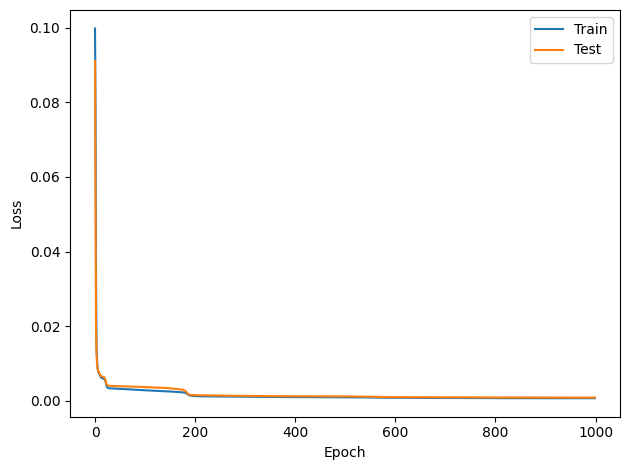

In [17]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [18]:
tmp_train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
tmp_val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

In [19]:
def make_preds(model, data_loader):
    loss_dist = []
    model.eval()
    for x, _ in data_loader:
        x = x.to(device)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
    return loss_dist  

In [20]:
def plot_loss_dist(loss_dist):
    loss = []
    for i in loss_dist:
        loss.append((i,i))
    plt.scatter(*zip(*loss))
    plt.show()
    plt.close()
    
    plt.hist(loss_dist, bins=50)
    plt.show()
    plt.close()

In [21]:
with torch.no_grad():
    for i, (x, y) in enumerate(tmp_train_loader):
        print(model.encode(x.to(device)))
        if i == 10:
            break
with torch.no_grad():
    for i, (x, y) in enumerate(tmp_train_loader):
        print(model(x.to(device)))
        if i == 1:
            break

tensor([[ 1.0570, -3.4736, -2.4253, -4.0645]], device='cuda:0')
tensor([[-1.6175, -1.7491, -3.8644, -3.6777]], device='cuda:0')
tensor([[-0.2923, -3.7906, -3.4470, -4.8970]], device='cuda:0')
tensor([[-0.2469, -3.4790, -3.5418, -4.6025]], device='cuda:0')
tensor([[-1.2897, -1.3794, -2.3558, -3.2535]], device='cuda:0')
tensor([[-0.6811, -2.5919, -3.7147, -4.0117]], device='cuda:0')
tensor([[-0.2825, -2.5341, -4.4083, -3.7694]], device='cuda:0')
tensor([[-2.6379, -0.8463, -1.3551, -3.4002]], device='cuda:0')
tensor([[-0.3163, -2.8921, -2.2726, -4.1549]], device='cuda:0')
tensor([[ 0.0269, -3.5863, -3.6043, -4.5759]], device='cuda:0')
tensor([[-0.4837, -3.6923, -3.4800, -4.8926]], device='cuda:0')
tensor([[1.8088e-02, 4.0113e-04, 8.6370e-05, 1.1808e-04, 1.1820e-04, 1.1584e-04,
         7.6720e-06, 2.2730e-02, 2.8633e-02, 3.7179e-02, 4.4271e-02, 3.9275e-02,
         2.4343e-01, 1.7821e-03, 3.9960e-02, 1.3847e-02, 2.8216e-03]],
       device='cuda:0')
tensor([[6.2792e-02, 4.4239e-02, 3.3437

In [22]:
train_loss_dist = make_preds(model, tmp_train_loader)

In [23]:
len(train_loss_dist)

1675

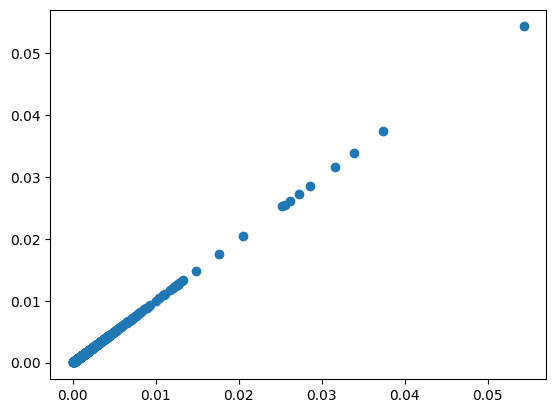

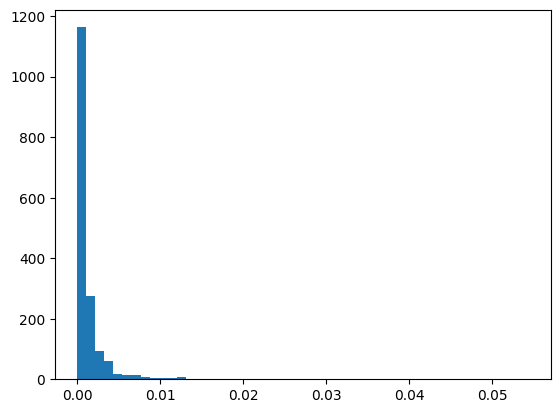

In [24]:
plot_loss_dist(train_loss_dist)

419


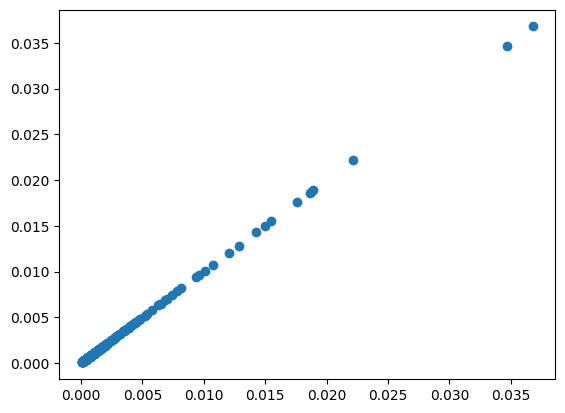

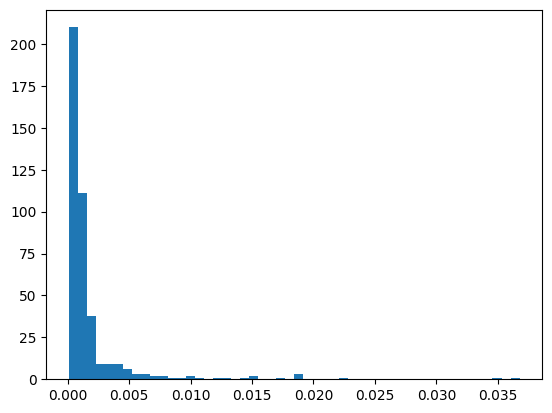

In [25]:
val_loss_dist = make_preds(model, tmp_val_loader)
print(len(val_loss_dist))
plot_loss_dist(val_loss_dist)

In [26]:
sorted_train = sorted(train_loss_dist, reverse=True)
print("Train", sorted_train[:10])
print("\n\n")

sorted_val = sorted(val_loss_dist, reverse=True)
print("Val", sorted_val[:10])
print("\n\n")

print(f"Train Mean: {statistics.mean(train_loss_dist)}, Median: {statistics.median(train_loss_dist)}")
print(f"Val Mean: {statistics.mean(val_loss_dist)}, Median: {statistics.mean(val_loss_dist)}")

Train [0.054346226155757904, 0.0374198742210865, 0.033900272101163864, 0.03157170116901398, 0.028570007532835007, 0.027266178280115128, 0.026193689554929733, 0.025501718744635582, 0.025246262550354004, 0.020497629418969154]



Val [0.03677613288164139, 0.034696660935878754, 0.02217756398022175, 0.018923809751868248, 0.018698524683713913, 0.01863235794007778, 0.017575979232788086, 0.015471583232283592, 0.014993485063314438, 0.014272362925112247]



Train Mean: 0.0014459766691891389, Median: 0.0007252904470078647
Val Mean: 0.0018116052529802667, Median: 0.0018116052529802667


In [27]:
threshold = np.mean(train_loss_dist) + 2*np.std(train_loss_dist)

1555


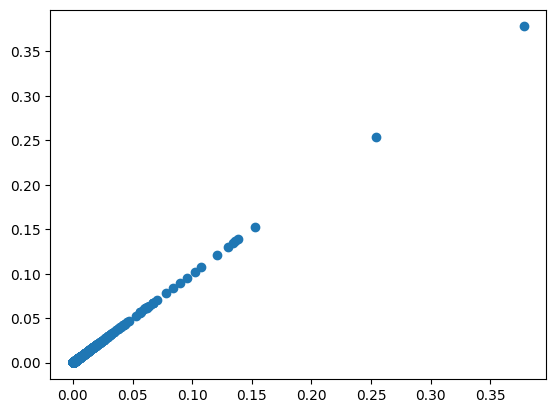

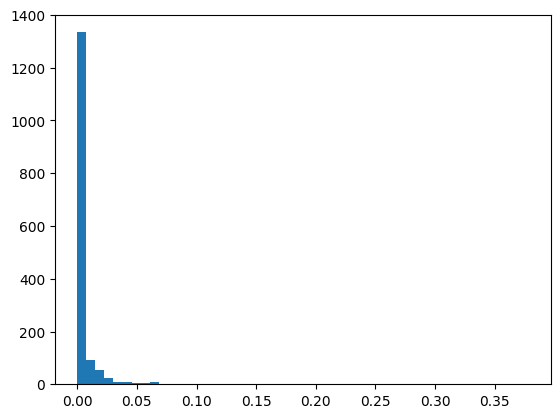

In [28]:
test_zero_loss_dist = make_preds(model, test_zero)
print(len(test_zero_loss_dist))
plot_loss_dist(test_zero_loss_dist)

In [29]:
sorted_test = sorted(test_zero_loss_dist, reverse=True)
print("Test zero", sorted_test[:10])
print("\n\n")

print(f"Test Mean: {statistics.mean(test_zero_loss_dist)}, Median: {statistics.median(test_zero_loss_dist)}")

Test zero [0.3781016170978546, 0.2540373206138611, 0.15277093648910522, 0.13877122104167938, 0.13626474142074585, 0.1340339034795761, 0.12969455122947693, 0.120919369161129, 0.10768947005271912, 0.10209459066390991]



Test Mean: 0.005885198459674348, Median: 0.0018003199947997928


In [30]:
np.percentile(train_loss_dist, 20), np.percentile(val_loss_dist, 20), np.percentile(test_zero_loss_dist, 20)

(0.00036606887006200854, 0.0003849193570204079, 0.0007094661355949939)

In [31]:
zero_below, zero_above = [], [] 
for i in test_zero_loss_dist:
    if i < 0.00015:
        zero_below.append(i)
    else:
        zero_above.append(i)
len(zero_below), len(zero_above)

(9, 1546)

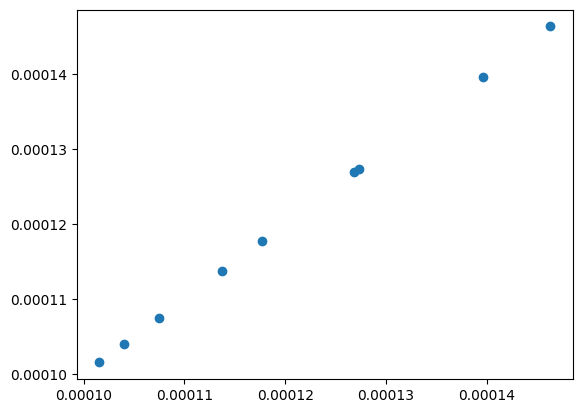

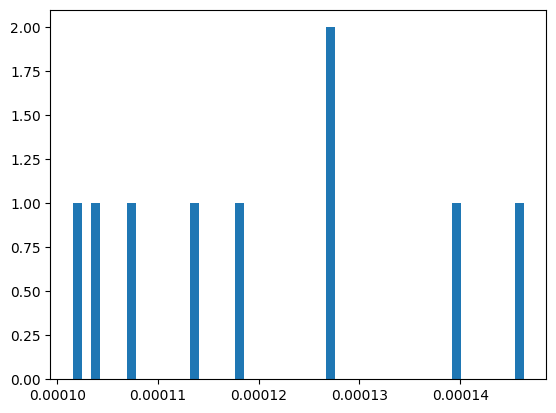

In [32]:
plot_loss_dist(zero_below)

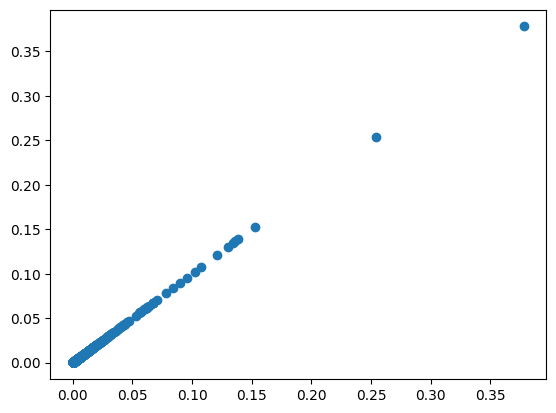

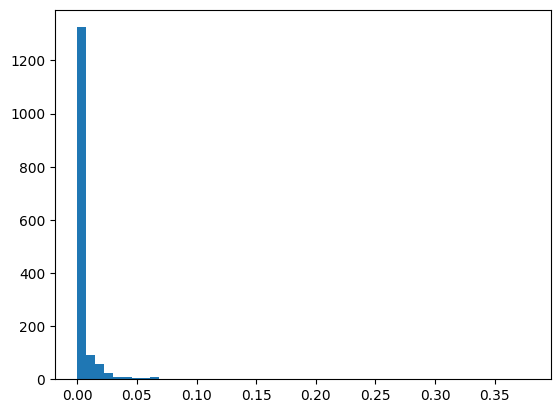

In [33]:
plot_loss_dist(zero_above)

In [34]:
test_loss_dist = make_preds(model, test_loader)
len(test_loss_dist)

1974

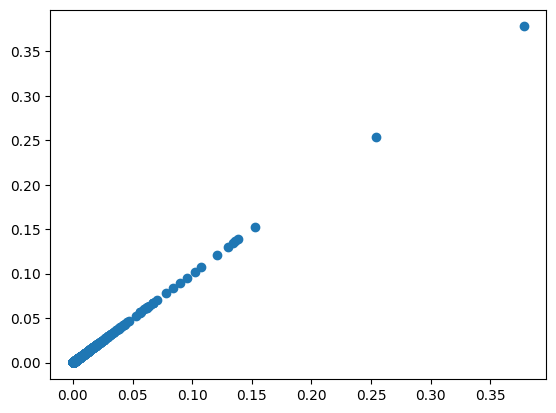

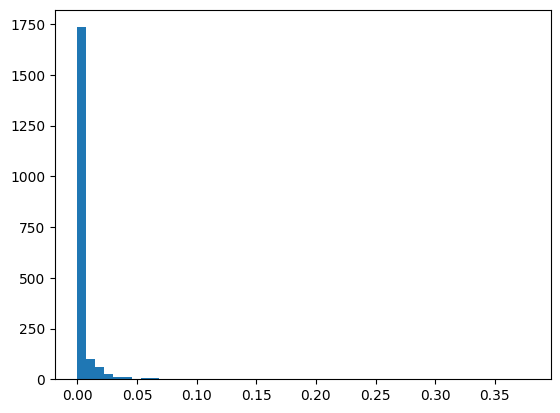

In [35]:
plot_loss_dist(test_loss_dist)

In [36]:
#total_losses = train_loss_dist[:]
#total_losses.extend(test_loss_dist)
total_losses = test_loss_dist
total_losses = np.array(total_losses)

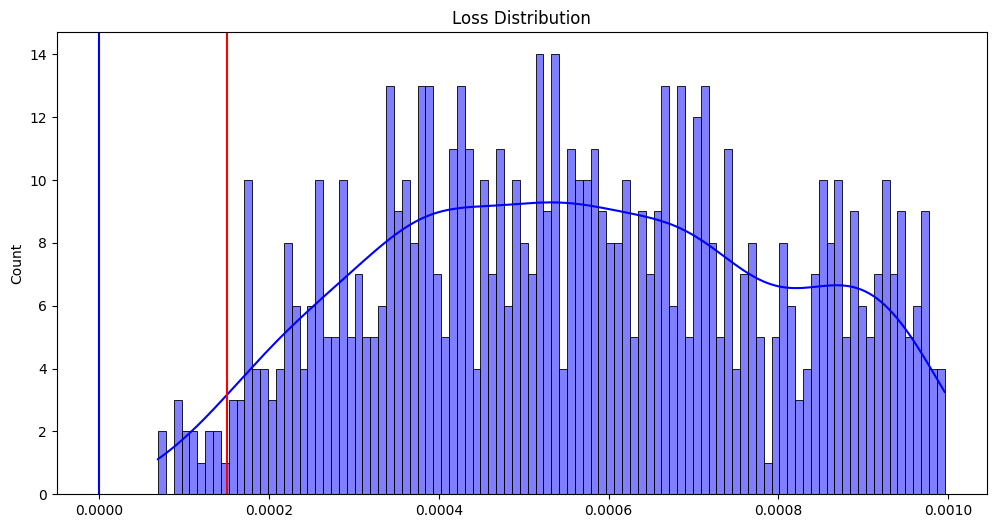

In [37]:
lower_threshold = 0.0
upper_threshold = 0.00015
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot( total_losses[total_losses < 0.001],bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [38]:
threshold

0.007359043549560059

In [39]:
def make_preds_and_classify(model, data_loader, threshold=1e-4):
    loss_dist = []
    y_true, y_pred = [], []
    y_scores = []
    model.eval()
    for x, y in data_loader:
        x = x.to(device)
        y_true.append(y)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
        if loss.item() < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
        # np.exp(-losses) / np.sum(np.exp(-losses))

    losses = np.array(loss_dist)
    probs = np.exp(-losses) / np.sum(np.exp(-losses))
    
    m = np.median(losses)
    ad = np.abs(losses - m)
    mad = np.median(ad)
    probs2 =1/(1 + np.exp(-0.6745 * ad / mad))
    
    scaler = MinMaxScaler()
    scaler.fit(probs2.reshape(-1, 1))
    probs3 = scaler.transform(probs2.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(probs.reshape(-1, 1))
    probs4 = scaler.transform(probs2.reshape(-1, 1))
    
    probs5 = 1/(1 + np.exp(-losses))
    print(probs5.min(), probs5.max())
    
    scaler = MinMaxScaler()
    scaler.fit(probs5.reshape(-1, 1))
    probs6 = scaler.transform(probs5.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(losses.reshape(-1, 1))
    probs7 = scaler.transform(losses.reshape(-1,1))
    
    
    y_true = torch.cat(y_true, dim=0)
    num_ones = torch.sum(y_true == 1).item()
    print("Num ones", num_ones)
    print("Considering", int(0.1 * num_ones), "thefts")
    
    acc, precision, recall, f1 = get_classification_metrics(y_true.numpy(), np.array(y_pred))
    
    print("Probs2:", get_probability_measures(y_true.numpy(), probs2))

    print("Probs2",get_lift_demotion_scores(y_true.numpy(), probs2,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs3:", get_probability_measures(y_true.numpy(), probs3))

    print("Probs3",get_lift_demotion_scores(y_true.numpy(), probs3,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    print("Probs4:", get_probability_measures(y_true.numpy(), probs4))

    print("Probs4",get_lift_demotion_scores(y_true.numpy(), probs4,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs5:", get_probability_measures(y_true.numpy(), probs5))

    print("Probs5",get_lift_demotion_scores(y_true.numpy(), probs5,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    print("Probs6:", get_probability_measures(y_true.numpy(), probs6))

    print("Probs6",get_lift_demotion_scores(y_true.numpy(), probs6,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    print("Probs7:", get_probability_measures(y_true.numpy(), probs7))

    print("Probs7",get_lift_demotion_scores(y_true.numpy(), probs7,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False))
    
    brier, roc_auc, pr_auc = get_probability_measures(y_true.numpy(), probs)

    lift, demotion, weighted = get_lift_demotion_scores(y_true.numpy(), probs,
                                                            num_samples=int(0.1 * num_ones),
                                                            verbose=False)
    
    return acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, losses
  

In [40]:
acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, loss_dist = make_preds_and_classify(model, test_loader, 
                        threshold=0.00015)
print(f"[Test] Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}\n"
                f"\t\tBrier score loss: {brier}, ROC-AUC: {roc_auc}, PR-AUC: {pr_auc}\n"
                f"\t\tLift: {lift}, Demotion: {demotion}, Weighted Score: {weighted}\n")

0.5000173049265799 0.5934151545893339
Num ones 1555
Considering 155 thefts
Probs2: (0.17773228402481583, 0.58351533662295, 0.854918412872949)
Probs2 (0.9354838709677419, 0.23225806451612904, 0.724516129032258)
Probs3: (0.3633614145593349, 0.58351533662295, 0.854918412872949)
Probs3 (0.9354838709677419, 0.23225806451612904, 0.724516129032258)
Probs4: (None, 0.58351533662295, 0.854918412872949)
Probs4 (0.9354838709677419, 0.23225806451612904, 0.724516129032258)
Probs5: (0.24895455341266842, 0.7052728514530846, 0.8910337437842871)
Probs5 (0.9354838709677419, 0.43870967741935485, 0.7864516129032257)
Probs6: (0.7651126080934051, 0.7052728514530846, 0.8910337437842871)
Probs6 (0.9354838709677419, 0.43870967741935485, 0.7864516129032257)
Probs7: (0.7653512753198813, 0.7052728514530846, 0.8910337437842871)
Probs7 (0.9354838709677419, 0.43870967741935485, 0.7864516129032257)
[Test] Accuracy: 0.7862208713272543, Precision: 0.7891781521184278, Recall: 0.9942122186495177, F1: 0.8799089356858281
		

In [41]:
np.percentile(loss_dist, 30)

0.0008451589150354266

In [42]:
print(f"Test Mean: {statistics.mean(loss_dist)}, Median: {statistics.median(loss_dist)}")

Test Mean: 0.005020540124514865, Median: 0.0015012017684057355


In [43]:
len(train_loss_dist), len(test_zero_loss_dist)

(1675, 1555)

In [44]:
train_loss_dist = np.array(train_loss_dist)
test_zero_loss_dist = np.array(test_zero_loss_dist)

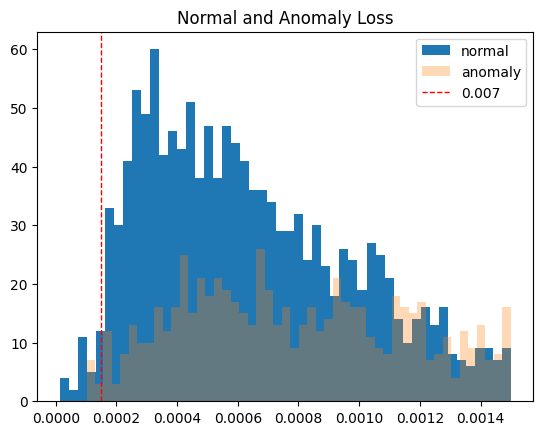

In [45]:
plt.hist(train_loss_dist[train_loss_dist < 0.0015], bins=50, label='normal')
plt.hist(test_zero_loss_dist[test_zero_loss_dist < 0.0015], bins=50, label='anomaly', alpha=0.3)
plt.axvline(0.00015, color='r', linewidth=1, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [46]:
m = np.median(loss_dist)
ad = np.abs(loss_dist - m)
mad = np.median(ad)
mad

0.0009978963062167168

In [47]:
0.6745 * ad / mad

array([1.14453709, 0.29402875, 1.40712068, ..., 2.24776135, 0.35694009,
       2.65972813])

In [48]:
pr =1/(1 + np.exp(-0.6745 * ad / mad))

In [49]:
pr.min(), pr.max(), pr.mean()

(0.5003302521001649, 1.0, 0.7080082150345639)

In [50]:
# MAD score

In [51]:
loss_dist[:10], loss_dist[-10:]

(array([0.0031945 , 0.0010662 , 0.00358298, 0.00120883, 0.00056275,
        0.00071129, 0.00153553, 0.00141371, 0.00166963, 0.01499349]),
 array([0.00038877, 0.00407777, 0.02000726, 0.00183068, 0.00075649,
        0.00281375, 0.00162754, 0.00482668, 0.00202928, 0.00543617]))

In [52]:
y_test[:10].values, y_test[-10:].values

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [53]:
scaler = MinMaxScaler()
scaler.fit(loss_dist.reshape(-1, 1))
probs = scaler.transform(loss_dist.reshape(-1,1))
probs[:10], probs[-10:]

(array([[0.00826723],
        [0.00263728],
        [0.00929487],
        [0.00301458],
        [0.00130553],
        [0.00169845],
        [0.00387881],
        [0.00355656],
        [0.00423352],
        [0.0394788 ]]),
 array([[0.00084529],
        [0.01060373],
        [0.05274161],
        [0.00465955],
        [0.00181802],
        [0.00726005],
        [0.00412218],
        [0.01258479],
        [0.0051849 ],
        [0.01419705]]))

In [54]:
probs_1 = []
for i, y in enumerate(y_test):
    if y == 1:
        probs_1.append(probs[i][0])
probs_1 = np.array(probs_1)

In [55]:
len(probs_1[probs_1 >= 0.00015])

1550

In [56]:
probs5 = 1/(1 + np.exp(-loss_dist))
probs5.min(), probs5.max()

(0.5000173049265799, 0.5934151545893339)

In [57]:
scaler = MinMaxScaler()
scaler.fit(probs5.reshape(-1, 1))
probs6 = scaler.transform(probs5.reshape(-1, 1))
probs6.min(), probs6.max()

(0.0, 1.0)

In [58]:
probs6[:10], probs6[-10:]

(array([[0.0083655 ],
        [0.00266863],
        [0.00940535],
        [0.00305041],
        [0.00132105],
        [0.00171864],
        [0.00392492],
        [0.00359884],
        [0.00428384],
        [0.03994734]]),
 array([[0.00085534],
        [0.01072977],
        [0.05336678],
        [0.00471494],
        [0.00183964],
        [0.00734635],
        [0.00417119],
        [0.01273436],
        [0.00524653],
        [0.01436578]]))

In [59]:
probs_1 = []
for i, y in enumerate(y_test):
    if y == 1:
        probs_1.append(probs6[i][0])
probs_1 = np.array(probs_1)

In [60]:
len(probs_1[probs_1 >= 0.00015])

1550